# Контекст. Интернет-магазин

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.  


Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Описание данных

**/datasets/hypothesis.csv** — выдвинутые гипотезы:  
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
 
**/datasets/orders.csv** — информация о заказах:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

**/datasets/visitors.csv** — информация об A/B тесте и пользователях:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Оглавление
1. [Шаг 1. Откройте файл с данными и изучите общую информацию](#step1)  
    1.1 [Вывод к Шагу 1](#step1.1)
    
        
2. [Шаг 2. Подготовка данных](#step2)  
    2.1  [Вывод к Шагу 2](#step2.1)     
  
    
3. [Шаг 3. Анализ A/B-теста](#step3)   
    3.1   [Фреймворк ICE для приоритизации гипотез](#step3.1)  
    3.2   [Фреймворк RICE для приоритизации гипотез](#step3.2)  
    
    
4. [Шаг 4. Приоритизация гипотез](#step4)   
    4.1   [График кумулятивной выручки по группам](#step4.1)  
    4.2   [График кумулятивного среднего чека по группам](#step4.2)  
    4.3   [График относительного изменения кумулятивного среднего чека группы B к группе A](#step4.3)  
    4.4   [График кумулятивной конверсии по группам](#step4.4)  
    4.5   [График относительного изменения кумулятивной конверсии группы B к группе A](#step4.5)   
    4.6   [Точечный график количества заказов по пользователям](#step4.6)   
    4.7   [95-й и 99-й перцентили количества заказов на пользователя](#step4.7)   
    4.8   [Точечный график стоимостей заказов](#step4.8)  
    4.9   [95-й и 99-й перцентили стоимости заказов](#step4.9)   
    4.10  [Статистическая значимость различий в конверсии между группами по «сырым» данным](#step4.10)  
    4.11  [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#step4.11)     
    4.12  [Статистическую значимость различий в конверсии между группами по «очищенным» данным](#step4.12)  
    4.13  [Статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным](#step4.13)    
    
    
 
4. [Шаг 5. Общий вывод. Принятие решения по результатам теста](#step5)  

### Шаг 1. Откройте файлы с данными и изучите общую информацию <a id="step1"></a>   
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats as st
import math
import numpy as np
from functools import reduce
import seaborn as sns
import datetime as dt
import scipy.stats as stats


hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [2]:
for data in [hypothesis, orders, visitors]:
    if data is hypothesis:
        print('\033[1m' + 'Датасет с данными о гипотезах' + '\033[0m')
    if data is orders:
        print('\033[1m' + 'Датасет с заказами' + '\033[0m')
    if data is visitors:
        print('\033[1m' + 'Датасет с данными A/B теста' + '\033[0m')
    

    print()
    print(data.info())
    display(data.head(10))
    print()
    print()

Датасет с данными о гипотезах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5




Датасет с заказами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B




Датасет с данными A/B теста

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


### Вывод<a id="step1.1"></a>   
</div>  

Мы получили абсолютно нормальные датасеты. В нашем распоряжении 9 гипотез, 1197 заказов и 62 группы в A/B тесте.  

В дальнейшем приведём даты к формату `datetime`. Проверим данные на дубликаты, в названиях столбцов уберём верхний регистр. 



### Шаг 2. Предобработка данных <a id="step2"></a>   
</div>  

Начнём с `hypothesis`. Уберём верхний регистр в названиях столбцов

In [3]:
print(hypothesis.columns)

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')


In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
print(hypothesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')


Аналогично поступим в регистром у `orders`

In [5]:
orders.columns = orders.columns.str.lower()

Теперь в `orders` и `visits` приведём даты к формату datetime

In [6]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим, нет ли неправильных значений в столбцах `group`

In [7]:
print('Проверка group в orders')
display(orders[['group']].apply(lambda x: x.value_counts()).T.stack())

print('Проверка group в visitors')
display(visitors[['group']].apply(lambda x: x.value_counts()).T.stack())

Проверка group в orders


group  B    640
       A    557
dtype: int64

Проверка group в visitors


group  A    31
       B    31
dtype: int64

В целом, полный порядок, никаких артефактов не замечано

Посмотрим на гистограмму для выручки от заказов

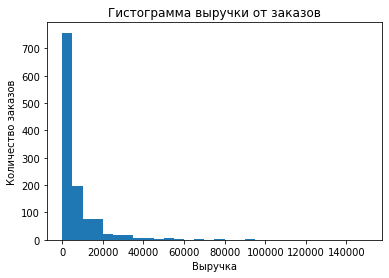

In [8]:
plt.hist(orders['revenue'], bins = 30, range = (0,150000))
plt.title('Гистограмма выручки от заказов')
plt.xlabel('Выручка')
plt.ylabel('Количество заказов')
plt.show()

Есть небольшой выброс по выручке после 60000, но в целом ничего критичного

Теперь посмотрим на гистограмму количества пользователей в указанную дату

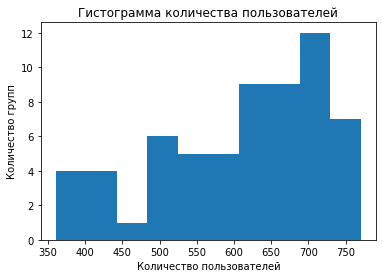

In [9]:
plt.hist(visitors['visitors'])
plt.title('Гистограмма количества пользователей')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество групп')
plt.show()

Здесь также не обнаружено артефактов, есть интересный момент с "просадкой" графика в районе групп с 440-490 пользователями, но в целом ничего серьёзного

Проверим датасеты на дубликаты

In [10]:
for data in [hypothesis, orders, visitors]:
    print(data.duplicated().sum())

0
0
0


С дубликатами проблем нет, идём дальше

Проверим нет ли у нас пользователей, которые совершили несколько заказов

In [11]:
users_more_orders = orders.groupby(['visitorid', 'group']).size().reset_index()
users_more_orders.columns = ['visitorid', 'group', 'count']
users_more_orders = users_more_orders.query('count > 1').sort_values(by='visitorid')
display(users_more_orders.head(5))

,visitorid,group,count
45,199603092,A,4
58,237748145,A,4
63,249864742,B,3
94,366673373,A,2
104,393266494,B,2


Проверим самого заказывающего пользователя 199603092

In [12]:
orders_bad_user = orders.query('visitorid == "199603092"')
display(orders_bad_user)

,transactionid,visitorid,date,revenue,group
26,2223239646,199603092,2019-08-15,3488,A
134,62794304,199603092,2019-08-22,6976,A
246,437656952,199603092,2019-08-02,3488,B
823,2971973105,199603092,2019-08-27,2790,A
1102,1941707234,199603092,2019-08-12,6438,A


Неприятный бонус, в наш A/B тест закралась ошибка, есть пользователи, которые успели попасть в результаты и **группу А** и **группы B**

### Вывод <a id="step2.1"></a>   
</div>  

В датасете не обнаружено дубликатов и пропущенных значений. Самые существенные проблемы были с типом данных у столбцов датами, а также с самим названием столбцов.

Самой серьезной проблемой является то, что некоторые пользователи были в двух группах A/B теста. Об этом нужно обязательно сообщить коллегам

Приступим к следующей части

### Шаг 3. Приоритизация гипотез. <a id="step3"></a>   
</div>  

Посмотрим на полное написание гипотез 

In [13]:
list(hypothesis['hypothesis'])

['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
 'Запустить собственную службу доставки, что сократит срок доставки заказов',
 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
 'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
 'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
 'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
 'Запустить акцию, дающую скидку на товар в день рождения']

**Применим фреймфорк `ICE`** для приоритизации гипотез и отсортируем по убыванию приоритета <a id="step3.1"></a>   
</div>  

Расчёт ведем по формуле: 
    
    
$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [14]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis = hypothesis.sort_values('ICE', ascending=False)
pd.set_option('display.max_colwidth',150)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


**Применим фреймфорк `RICE`** для приоритизации гипотез и отсортируем по убыванию приоритета <a id="step3.2"></a>   
</div>  

Расчёт ведём по формуле: 
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [15]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis = hypothesis.sort_values('RICE', ascending=False)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Для наглядности построим график с нанесением полученных параметров

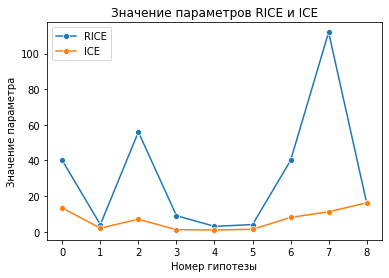

In [16]:
sns.lineplot(data=hypothesis['RICE'], marker='o', label = 'RICE')
sns.lineplot(data=hypothesis['ICE'], marker='o', label = 'ICE')
plt.title('Значение параметров RICE и ICE')
plt.xlabel('Номер гипотезы')
plt.ylabel('Значение параметра')
plt.show()

Как видно из таблицы и графика выше охват (`reach`) достаточно серьезно повлиял на вопрос приоритизации. 

Если в расчёте **ICE** лидерами были гипотезами под номерами **8,0,7,6 и 2** (в порядке убывания их значения), то в **RICE** в абсолютные лидеры выбилась **7 гипотеза**.   

7 гипотеза затрагивает намного большо пользователей, что читается и в её описании *Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*.  

### Шаг 4. Анализ A/B-теста. <a id="step4"></a>   
</div>  

### Построим график кумулятивной выручки по группам <a id="step4.1"></a>   
</div>  

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData` со столбцами:
- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — количество заказов в указанную дату в указанной группе;
- `buyers` — количество пользователей, совершивших хотя бы 1 заказ в указанную дату в указанной группе;
- `revenue` — выручка в указанную дату в указанной группе (средний чек);
- `visitors` — количество посетителей интернет-магазина в указанную дату в определённой группе.

Cоздаем массив уникальных пар значений дат и групп теста

In [17]:
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.

Получим строки таблицы `orders`, дата которых меньше или равна дате элемента из *datesGroups*, а группа теста равна группе из *datesGroups*.  

После этого агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец `group` не пропал из итогового вывода.   

Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков:

In [18]:
ordersAggregated = datesGroups.apply(
	lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])




По аналогии с `orders` поступаем и с `visitors`.

In [19]:
visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])



Объединим все данные в в одной таблице *cumulativeData* и выведем первые 5 строк получившейся таблицы

In [20]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativeData.head(5)) 



,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Теперь создадим датафреймы для групп **A** и **B** с кумулятивным количеством заказов и кумулятивной выручкой.   
Для наглядности построим график выручки для каждой группы

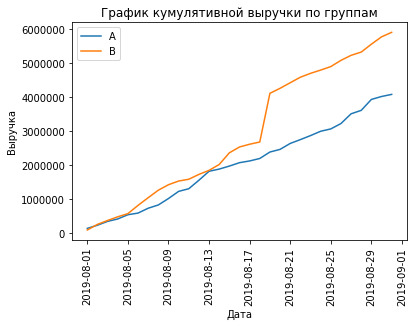

In [21]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xlabel('Дата')
plt.xticks(rotation=90)

plt.show()

К группе **A** претензий нет, а вот у группы **B** есть резкий скачок в районе 18-19 августа, возможно имел место небольшой выброс.  
Возможно влияние оказывают большие заказы, на которые мы обращали внимание в процессе подготовки данных. 

### Построим график кумулятивного среднего чека по группам <a id="step4.2"></a>   
</div>  

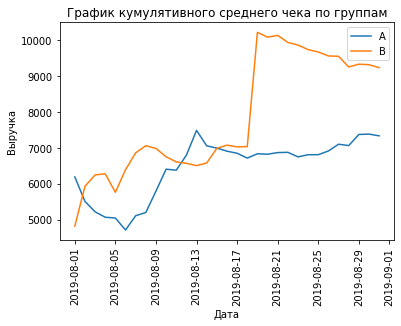

In [22]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

Наше предположение продолжает подтверждаться, кто-то очень богатый закупился 18-19 августа. 

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A <a id="step4.3"></a>   
</div>  

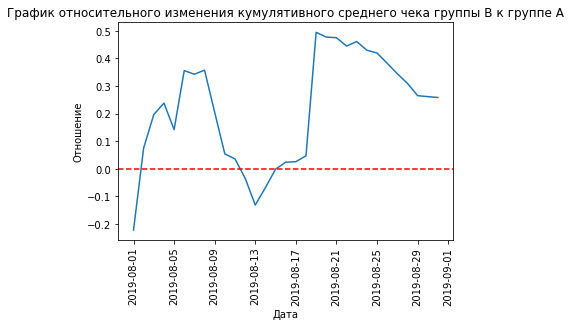

In [23]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)


plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel("Отношение")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

Ожидаемо группы шли сравнительно наравне до зафиксированной аномалии 18-19 августа, после чего группа **B** вырвалась значительно вперёд

### Построим график кумулятивной конверсии по группам <a id="step4.4"></a>   
</div>  

Добавим столбец `conversion` к нашей таблице

In [24]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Определим данные для каждой из групп и построим график кумулятивной конверсии 

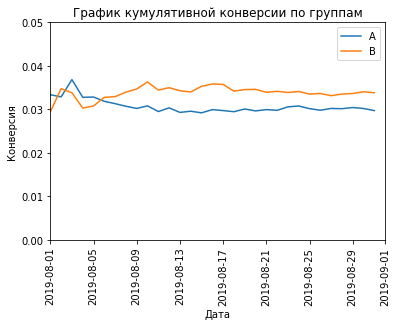

In [25]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Конверсия")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.legend()


#добавим масштаб, чтобы понимать установилась ли среднее значение конверсии
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])
plt.show()

Из графиков видно, что конверсия группы **A** остается установилась на среднем значении 0.030.  
C группой **B** ситуация чуть интереснее, конверсия находится в районе среднего 0.034

### Построим график относительного изменения кумулятивной конверсии группы B к группе A <a id="step4.5"></a>   
</div>  

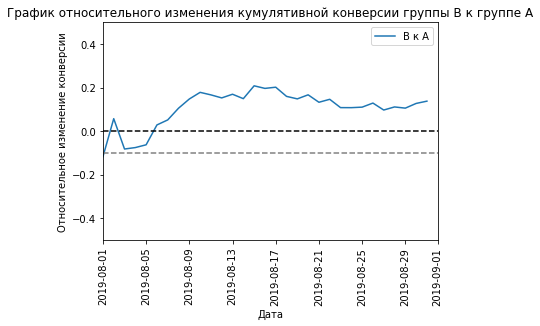

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="B к A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.ylabel("Относительное изменение конверсии")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])
plt.show()

Несмотря на все подозрения к группе **B**, она лидировала по конверсии начиная с 7 августа.  
Хотя и был заметен небольшой спад в районе 20-ых чисел августа, ближе к концу месяца лидерство вновь стало упрочняться. 

### Построим точечный график количества заказов по пользователям <a id="step4.6"></a>   
</div>  

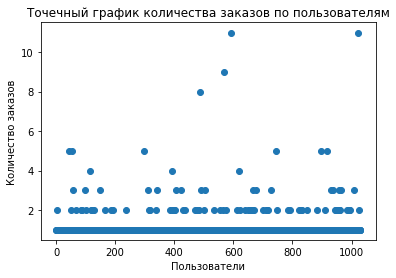

In [27]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsers.columns = ['visitorid','orders']
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel("Количество заказов")
plt.xlabel('Пользователи')
plt.show()


Большинство заказов совершает совершает *1 заказ*. Редкое явление для пользователя - это совершение *больше 3 заказов*. Совсем редко совершается больше *5 заказов*.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя <a id="step4.7"></a>   
</div>  

In [28]:
print('95-й и 99-й перцентили количества заказов на пользователя:', np.percentile(ordersByUsers['orders'], [95, 99])) 

95-й и 99-й перцентили количества заказов на пользователя: [2. 4.]


Таким образом, всё, что находится за 99% перцентилем можно признать аномалией.

### Построим точечный график стоимостей заказов. <a id="step4.8"></a>   
</div>  

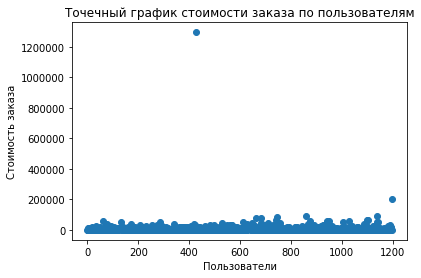

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title('Точечный график стоимости заказа по пользователям')
plt.ylabel("Стоимость заказа")
plt.xlabel('Пользователи')
plt.show()

Видим два очевидных выброса

### Посчитаем 95-й и 99-й перцентили стоимости заказов <a id="step4.9"></a>   
</div>  

In [30]:
print('95-й и 99-й перцентили стоимости заказов соответственно:', np.percentile(orders['revenue'], [95, 99])) 

95-й и 99-й перцентили стоимости заказов соответственно: [28000.  58233.2]


Данные подтверждаются и графиком. 99% перцентиль - **наша граница**, за которой только аномальные заказы

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным <a id="step4.10"></a>   
</div>  

- `date` — датаcет;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Соберём все данные в `data` и выведем первые 5 строк на экран

In [31]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

display(data.head(5)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `visitorid, orders`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [32]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorid', 'orders'] 

Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [33]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')] 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

в `sampleA` сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов `sampleA` — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке `sampleA` методом `mean`.     


Аналогично найдём конверсию группы B: `SampleB.mean()`.  


Выведем относительный прирост конверсии группы B: `конверсия группы B / конверсия группы A - 1`.   

Округлим до трёх знаков после запятой.

Нулевая гипотеза H<sub>0</sub> - конверсия в **группе А** ***равна*** конверсии в **группе В**  
Альтернативная гипотеза H<sub>1</sub> - конверсия в **группе А** ***не равна*** конверсии в **группе В**  

In [34]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorid', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.008
0.138


Первое число — **p-value** = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, **не получилось отвергнуть**.  

Однако относительный выигрыш **группы B** равен **13.8%** — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. <a id="step4.11"></a>   
</div>  

Нулевая гипотеза H<sub>0</sub> - Средний чек **группы А** ***не больше*** среднего чека в **группе В**  
Альтернативная гипотеза H<sub>1</sub> - Средний чек в **группе А** ***больше*** среднего чека в **группе В**  

In [35]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


В этот раз **p-value** больше 0.05. Мы не отвергаем нулевую гипотезу, а значит мы будем считать, что в среднем чеке нет различий.   

Отдельно обращаем внимание на то, что средний чек **группы B** значительно выше среднего чека **группы А**

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным <a id="step4.12"></a>   
</div>  

Будем считать пользователей, у которых больше **4 заказов** и сделанные заказы дороже **58233** рублей, соучастниками аномалии, то есть уберем их из "очищенных" данных

Сделаем срезы пользователей с числом заказов больше 4 — `usersWithManyOrders` и пользователей,c овершивших заказы дороже 58 233 рублей — `usersWithExpensiveOrders`.   
Объединим их в таблице `abnormalUsers`. Выведем 5 первых значений и длину получившейся таблицы

In [36]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorid'], ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorid']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(5))
print('Длина таблицы:', abnormalUsers.shape) 

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitorid, dtype: int64

Длина таблицы: (15,)


Всего 15 аномальных пользователей. Посмотрим на их статистическую значимость

In [37]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

Нулевая гипотеза H<sub>0</sub> - конверсия в "очищенной" **группе А** ***равна*** конверсии в "очищенной" **группе В**  
Альтернативная гипотеза H<sub>1</sub> - конверсия в  "очищенной" **группе А** ***не равна*** конверсии в "очищенной" **группе В**  

In [38]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
0.153


Результаты по конверсии почти не изменились. Посмотрим на изменения по среднему чеку

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным <a id="step4.13"></a>   
</div>  

Нулевая гипотеза H<sub>0</sub> - Средний чек "очищенной" **группы А** ***не больше*** среднего чека в "очищенной" **группе В**  
Альтернативная гипотеза H<sub>1</sub> - Средний чек в "очищенной" **группе А** ***больше*** среднего чека в "очищенной" **группе В**  

In [39]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

0.425
-0.006


А здесь изменения, что называется, на лицо. **p-value** все также не дает нам отвёргнуть гипотезу.  

Но, что очень важно, от преимущества **группы B** ничего не осталось. Мало того, она даже стала немного проигрывать по среднему чеку **группе A**.

### Построим графики по кумулятивной выручки, среднему чеку и конверсии для очищенных данных <a id="step4.14"></a>   
</div>  



Создадим датасет с "очищенными" данными

In [40]:
good_orders = orders[~orders['visitorid'].isin(abnormalUsers)]
display(good_orders)


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


Используя код выше, построим графики для кумулятивной выручки для очищенных групп

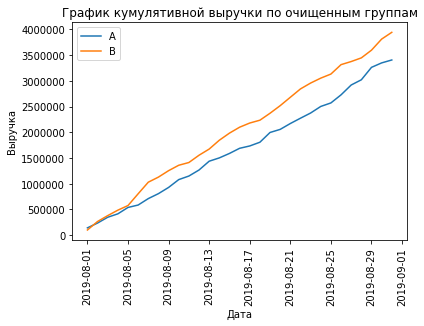

In [41]:
good_datesGroups = good_orders[['date','group']].drop_duplicates()

good_ordersAggregated = good_datesGroups.apply(
	lambda x: good_orders[np.logical_and(good_orders['date'] <= x['date'], good_orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

good_visitorsAggregated = good_datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

good_cumulativeData = good_ordersAggregated.merge(good_visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
good_cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

good_cumulativeRevenueA = good_cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
good_cumulativeRevenueB = good_cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.plot(good_cumulativeRevenueA['date'], good_cumulativeRevenueA['revenue'], label='A')
plt.plot(good_cumulativeRevenueB['date'], good_cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по очищенным группам')
plt.ylabel("Выручка")
plt.xlabel('Дата')
plt.xticks(rotation=90)

plt.show()

Аналогично строим график кумулятивного среднего чека по очищенным данным

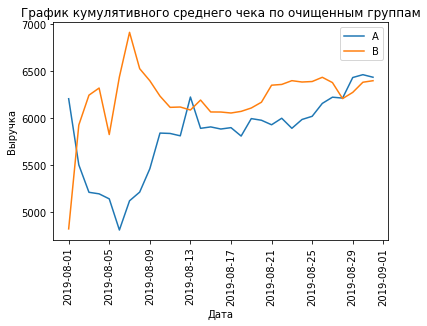

In [42]:
plt.plot(good_cumulativeRevenueA['date'], good_cumulativeRevenueA['revenue']/good_cumulativeRevenueA['orders'], label='A')
plt.plot(good_cumulativeRevenueB['date'], good_cumulativeRevenueB['revenue']/good_cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по очищенным группам')
plt.ylabel("Выручка")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

Обратим внимание, что что-то необычное случилось с **группой А** в периоде с 6 августа по 9 августа. Нужно обсудить с коллегами возможные внешние причины. 

Посмотрим на относительное изменеие кумулятивного среднего чека

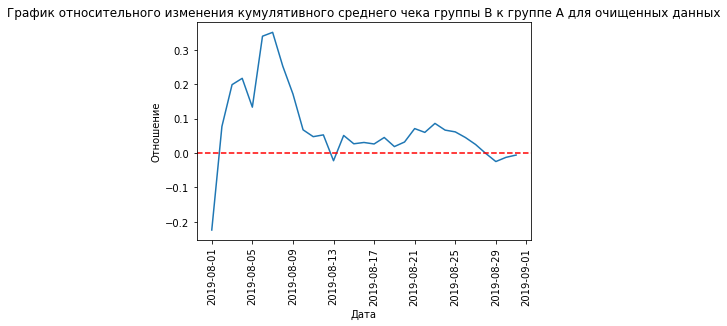

In [43]:
good_mergedCumulativeRevenue = good_cumulativeRevenueA.merge(good_cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


plt.plot(good_mergedCumulativeRevenue['date'], (good_mergedCumulativeRevenue['revenueB']/good_mergedCumulativeRevenue['ordersB'])/(good_mergedCumulativeRevenue['revenueA']/good_mergedCumulativeRevenue['ordersA'])-1)


plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A для очищенных данных')
plt.ylabel("Отношение")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

График подтверждает наше исследование. Относительное изменение в тиоге выравнивается и стремится к нулю. Это легко объясняется тем, что A/B тест не должен так сильно влиять на средний чек (если речь идёт не про тестирование цены)

Теперь построим график кумулятивной конверсии по очищенным данным

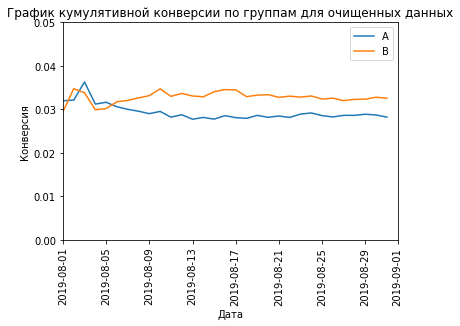

In [44]:
good_cumulativeData['conversion'] = good_cumulativeData['orders']/good_cumulativeData['visitors']
good_cumulativeDataA = good_cumulativeData[good_cumulativeData['group']=='A']
good_cumulativeDataB = good_cumulativeData[good_cumulativeData['group']=='B']

plt.plot(good_cumulativeDataA['date'], good_cumulativeDataA['conversion'], label='A')
plt.plot(good_cumulativeDataB['date'], good_cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам для очищенных данных')
plt.ylabel("Конверсия")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.legend()


#добавим масштаб, чтобы понимать установилась ли среднее значение конверсии
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])
plt.show()

**Группа B** не растеряла своё преимущество и на графиках. 

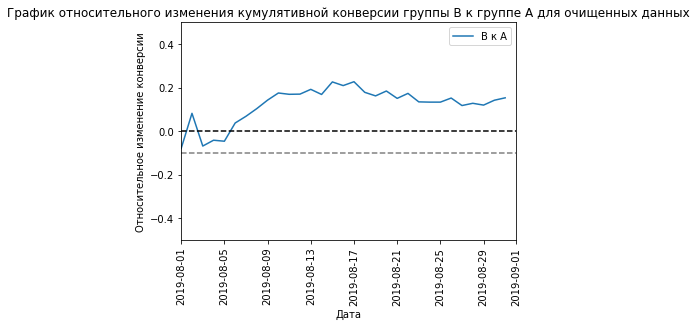

In [45]:
good_mergedCumulativeConversions = good_cumulativeDataA[['date','conversion']].merge(good_cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(good_mergedCumulativeConversions['date'], good_mergedCumulativeConversions['conversionB']/good_mergedCumulativeConversions['conversionA']-1, label="B к A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A для очищенных данных')
plt.ylabel("Относительное изменение конверсии")
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])
plt.show()

График совпадает с нашим предположением выше, **группа B** показывает себя лучше в части конверсии

### Шаг 5. Общий вывод. Принятие решения по результатам теста  <a id="step5"></a>   
</div>    




В завершении мы имеем следующие факты

- Есть статистически значимое различие по конверсии между группами и по «сырым», и по данным после фильтрации аномалий. **Группа B** более успешна в конверсии;
- Нет статистически значимого различия как по среднему чеку между группами по «сырым» данным, так и после фильтрации. При этом после очистки **группа B** потеряла значительную часть своего успеха;
- График различия конверсии между группами сообщает, что результаты **группы B** ***лучше*** **группы A**. Тенденции к ухудшению результатов **группы В** нет (по крайне мере графики развиваются идентично)

Исходя из обнаруженных фактов и при учёте того факта, что выборка в интернет-магазине сделана за *1 месяц* (то есть важно понимать, что сделки совершаются значительно быстрее, чем за 30 дней), можно рекомендовать **остановку теста и начало работы по стратегии группы B**.  

Отдельно нужно обратить внимание коллег на то, что некоторые пользователи, совершившие несколько заказов попали в обе группы. Этого нужно обязательно избежать в будущих A/B тестах. 
